## Results metrics

A threshold "T" is used to classify a test case to be either a correct (true or positive) case or false (negative) case. If the case is below a threshold "T" then it is classified false (negative) and if it is above threshold "T" it is classified true (positive).

**FPIR**: is the false positive identification rate. It is the ratio of the test cases that are classified as true cases although they are false cases. It is type I error. 
FPIR= Number of test cases classified above threshold "T" (true) / Number of all test cases

**FNIR**: is the false negative identification rate. It is  the ratio of the test cases that are classified as false cases although they are true cases. It is type II error.
FNIR= Number of test cases classified below threshold "T" (false) / Number of all test cases

In [1]:
# Load libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
# import torch
import seaborn as sns
import pandas as pd
sns.set(style="white")
%matplotlib inline

In [2]:
# load utils
import sys
sys.path.insert(0, '../utils')
from MagFace_utils.MagFace_funcs_1 import *


In [3]:
# Convert child ids to real ids as in child_balanced.

# For all Ids, get last id name and convert to unique ids
def convert_unique_ids(ids):
    unique_ids_list = []
    for id in ids:
        im_name = id.split("/")[-1][:-4]
        if '.' in im_name:
            un_id = im_name[:-5]
        else:
            un_id = "_".join(im_name.split("_")[:-1])

        unique_ids_list.append(un_id)
    return unique_ids_list

# Get unique ids
def factorize_ids(ids):
    unique_ids = {}
    factors = []
    for id in ids:
        if id not in unique_ids:
            unique_ids[id] = len(unique_ids)  # Assign a unique index for each unique ID
        factors.append(unique_ids[id])  # Append the index corresponding to the ID
    return factors, unique_ids


In [4]:
# load childrens feature vectors and load adults featur vector
with open('../data/feat_children.list', 'r') as f:
    lines = f.readlines()
img_2_feats = {}
img_2_mag = {}
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector

imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images
feats = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat_c = np.dot(feats, feats.T)
sim_scores_c = sim_mat_c.copy()
plot_sims = sim_scores_c[sim_scores_c < 0.9999].reshape(-1)


In [5]:

with open('../data/feat_adults_new.list', 'r') as f:
    lines = f.readlines()

img_2_feats = {}
img_2_mag = {}
# Convert to dictionary as adaface - is done in img_2_feats
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector
imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images
feats_a = np.array([img_2_feats[imgnames[ele]] for ele in range(len(lines))]) #unsorted image quality
ids_a = np.array([imgnames[ele] for ele in range(len(lines))])

sim_mat_a = np.dot(feats_a, feats_a.T)
ids_a = convert_unique_ids(ids_a)
factors_a, unique_ids = factorize_ids(ids)


sim_scores_a = sim_mat_a.copy()
plot_sims_a = sim_scores_a[sim_scores_a < 0.999].reshape(-1)


In [8]:

# Mated and non-mated ids
a_df = pd.read_csv('../data/adults_balanced.csv')
c_df = pd.read_csv('../data/child_balanced.csv')
# can_df = pd.read_csv('../data/can_balanced.csv')
# a_df = pd.read_csv('/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/loadings/mated_adults_image_info.csv')
# c_df = pd.read_csv('/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/loadings/mated_children_image_info.csv')


# load the OFIQ csv for children and adults

df_c_ofiq = pd.read_csv("../data/OFIQ_results/children_all_final.csv", sep=";")
df_a_ofiq = pd.read_csv("../data/OFIQ_results/adults_all_final.csv", sep=";")
df_can_ofiq = pd.read_csv("../data/OFIQ_results/canonical_children.csv", sep=";")
poor_c_ofiq = df_c_ofiq[df_c_ofiq['UnifiedQualityScore.scalar'] > 29]
poor_a_ofiq = df_a_ofiq[df_a_ofiq['UnifiedQualityScore.scalar'] > 29]
poor_can_ofiq = df_can_ofiq[df_can_ofiq['UnifiedQualityScore.scalar'] > 29]

def extract_identifier(filepath):
    filename = filepath.split('/')[-1]
    parts = filename.split('.')
    if parts[-2].isdigit():
        identifier = '.'.join(parts[-3:-1])
    else:
        identifier = '.'.join(parts[:-1])  # Join everything except the extension
    return identifier

# Apply the function on the DataFrame column
poor_a_ofiq['Identityname'] = poor_a_ofiq['Filename'].apply(extract_identifier)
poor_c_ofiq['Identityname'] = poor_c_ofiq['Filename'].apply(extract_identifier)
poor_can_ofiq['Identityname'] = poor_can_ofiq['Filename'].apply(extract_identifier)


subset_a_df = a_df[a_df['img_name'].isin(poor_a_ofiq['Identityname'])]
subset_c_df = c_df[c_df['img_name'].isin(poor_c_ofiq['Identityname'])]
# subset_can_df = can_df[can_df['img_name'].isin(poor_can_ofiq['Identityname'])]


/tmp/ipykernel_116255/1882593794.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor_a_ofiq['Identityname'] = poor_a_ofiq['Filename'].apply(extract_identifier)
/tmp/ipykernel_116255/1882593794.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poor_c_ofiq['Identityname'] = poor_c_ofiq['Filename'].apply(extract_identifier)


In [9]:
poor_a_ofiq['UnifiedQualityScore.scalar']

0       42
3       32
5       87
6       86
7       35
        ..
3457    61
3461    65
3462    89
3464    62
3466    70
Name: UnifiedQualityScore.scalar, Length: 2234, dtype: int64

In [15]:
a_mated_ids

Index(['m.01jscz', 'm.02729k2', 'm.0281mp2', 'm.02vldwh', 'm.02x1rwq',
       'm.03c6hwt', 'm.04nzf7', 'm.0515p2', 'm.051jw_', 'm.052vh2',
       'm.05p9q60', 'm.05syl08', 'm.06zq52', 'm.0cf93t'],
      dtype='object', name='im_id')

In [21]:
subset_a_df[subset_a_df.im_id == 'm.0cf93t']

,img_name,im_id,ethnicity,id_class,face_id,Age,children_agegroup
1866,m.0cf93t_0003,m.0cf93t,Asian,0cf93t,3,36,NaN
2314,m.0cf93t_0005,m.0cf93t,Asian,0cf93t,5,33,NaN


In [11]:

a_mates = subset_a_df.groupby("im_id").agg({'im_id': ['count']})
a_mated_ids = a_mates[a_mates[('im_id', 'count')] > 1].index
a_nonmated_ids = a_mates[a_mates[('im_id', 'count')] == 1].index


c_mates = subset_c_df.groupby("im_id").agg({'im_id': ['count']})
c_mated_ids = c_mates[c_mates[('im_id', 'count')] > 1].index
c_nonmated_ids = c_mates[c_mates[('im_id', 'count')] == 1].index


# Mated and non-mated ids
# can_mates = can_df.groupby("im_id").agg({'im_id': ['count']})
# can_mated_ids = can_mates[can_mates[('im_id', 'count')] > 1].index
# can_nonmated_ids = can_mates[can_mates[('im_id', 'count')] == 1].index

In [10]:
# check if any name from a_nonmated_ids.im_id appear in /mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/loadings/mated_adults_image_info.csv
mated_adults_image_info = pd.read_csv('/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/notebooks/loadings/mated_adults_image_info.csv')
len(mated_adults_image_info[mated_adults_image_info['identity_name'].isin(a_nonmated_ids)])


574

In [11]:
# children

ids = convert_unique_ids(ids)
factors_c, unique_ids = factorize_ids(ids)


## Threshold set based on studying the similarity scores
thold_c = np.percentile(plot_sims, 99)
im_ids_c = np.array(factors_c)

mated_df = c_mated_ids
non_mated_df = c_nonmated_ids
sim_scores = sim_scores_c
im_ids = im_ids_c
ids = ids

fnir_c = compute_fnir(c_mated_ids, sim_scores, im_ids_c, ids, thold=thold_c)
fpir_c = compute_fpir(c_nonmated_ids, sim_scores, im_ids_c, ids, thold=thold_c)

print("FNIR for children: ", fnir_c)
print("FPIR for children: ", fpir_c)

FNIR for children:  (0.48717948717948717, array([0.85544998, 0.85544998, 0.84072569, ..., 0.07851467, 0.66417667,
       0.66417667]))
FPIR for children:  (1.3315436241610739, array([0.72422793, 0.67901897, 0.29993762, ..., 0.45288209, 0.28783875,
       0.28300633]), array([[1.        , 0.72422793, 0.67901897, ..., 0.10887856, 0.16981499,
        0.1959246 ],
       [0.72422793, 1.        , 0.7677642 , ..., 0.16553825, 0.17820952,
        0.29758607],
       [0.67901897, 0.7677642 , 1.        , ..., 0.19140869, 0.08421105,
        0.19525943],
       ...,
       [0.10887856, 0.16553825, 0.19140869, ..., 1.        , 0.28783875,
        0.28300633],
       [0.16981499, 0.17820952, 0.08421105, ..., 0.28783875, 1.        ,
        0.66417667],
       [0.1959246 , 0.29758607, 0.19525943, ..., 0.28300633, 0.66417667,
        1.        ]]))


In [12]:
mated_sim_scores_child_below_29 = fnir_c[1]
nonmated_sim_scores_child_below_29 = fpir_c[1]

In [13]:
np.save('mated_sim_scores_child_below_29.npy', mated_sim_scores_child_below_29)
np.save('nonmated_sim_scores_child_below_29.npy', nonmated_sim_scores_child_below_29)


### adults

In [12]:
# adults
## Threshold set based on studying the similarity scores
thold_a = np.percentile(plot_sims_a, 99)
im_ids_a = np.array(factors_a)

mated_df = a_mated_ids
non_mated_df = a_nonmated_ids
sim_scores = sim_scores_a
im_ids = im_ids_a
ids = ids_a

fnir_a = compute_fnir(mated_df, sim_scores_a, im_ids, ids, thold=thold_a)
fpir_a = compute_fpir(non_mated_df, sim_scores_a, im_ids, ids, thold=thold_a)


In [14]:
fnir_a

(0.0,
 array([0.52638644, 0.52638644, 0.4456527 , 0.4456527 , 0.58511219,
        0.48827342, 0.58511219, 0.45511159, 0.48827342, 0.45511159,
        0.76413406, 0.76413406, 0.54734365, 0.54734365, 0.27932374,
        0.20484915, 0.27932374, 0.54074685, 0.20484915, 0.54074685,
        0.34600735, 0.53585463, 0.34600735, 0.38214526, 0.53585463,
        0.38214526, 0.28382528, 0.28382528, 0.38684709, 0.38684709,
        0.5084038 , 0.5084038 , 0.49773424, 0.49773424, 0.20359328,
        0.20359328, 0.4064335 , 0.4064335 , 0.43578232, 0.45275664,
        0.43578232, 0.46005252, 0.45275664, 0.46005252]))

In [13]:
print("FNIR for adults: ", fnir_a[0])
print("FPIR for adults: ", fpir_a[0])


FNIR for adults:  0.0
FPIR for adults:  1.1223628691983123


In [16]:
mated_sim_scores_adult_below_29 = fnir_a[1]
nonmated_sim_scores_adult_below_29 = fpir_a[1]

In [17]:
np.save('mated_sim_scores_adult_below_29.npy', mated_sim_scores_adult_below_29)
np.save('nonmated_sim_scores_adult_below_29.npy', nonmated_sim_scores_adult_below_29)

In [18]:
thold_a

0.4825735789771279

In [19]:
thold_c

0.4752905018186878

In [20]:
# Total number of transactions = n child ids + n adult ids
n_child_ids = len(im_ids_c)
n_adult_ids = len(im_ids_a)
n = n_child_ids + n_adult_ids

In [21]:
# FPD = fpir_c/fpir_a
# print("FPD result: ", FPD)


# FND = fnir_c/fnir_a
# print("FND result: ", FND)



FPD = fpir_c[0]/fpir_a[0]
print("FPD result: ", FPD)


FND = fnir_c[0]/(fnir_a[0]+0.00000001)
print("FND result: ", FND)


FPD result:  1.1863753343089267
FND result:  48717948.71794871


# GARBE

In [22]:
alpha_val = 0.2
GARBE = alpha_val * FPD + (1 - alpha_val) * FND
print("GARBE result MagFace: ", GARBE)

GARBE result MagFace:  38974359.21163403


# DET

In [23]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns

import sys
sys.path.insert(0, '../../utils')
from DET_utils.DET import DET
from DET_utils.DET_plots import *



mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [24]:
mated_scores1 = np.load('mated_sim_scores_child_below_29.npy')
nonmated_scores1 = np.load('nonmated_sim_scores_child_below_29.npy')
scores_type1 = "similarity"

mated_scores2 = np.load('mated_sim_scores_adult_below_29.npy')
nonmated_scores2 = np.load('nonmated_sim_scores_adult_below_29.npy')
scores_type2 = "similarity"


In [25]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index()


/tmp/ipykernel_113809/2890155579.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system1_df.round(round_digits).style.hide_index()


Statistic,Mated,Non-mated
Observations,2328.000000,3529740.000000
Minimum,0.078510,-0.377520
Maximum,0.989440,0.984690
Mean,0.655360,0.143270
St. Dev.,0.145790,0.136870
Skewness,-0.541480,0.224060
Ex. Kurtosis,0.198640,-0.091380


In [26]:
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
stats_system2_df.round(round_digits).style.hide_index()

/tmp/ipykernel_113809/1952787033.py:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  stats_system2_df.round(round_digits).style.hide_index()


Statistic,Mated,Non-mated
Observations,44.000000,939638.000000
Minimum,0.203590,-0.308030
Maximum,0.764130,0.844750
Mean,0.442560,0.214890
St. Dev.,0.128140,0.119370
Skewness,0.076820,0.005680
Ex. Kurtosis,0.422820,-0.036050


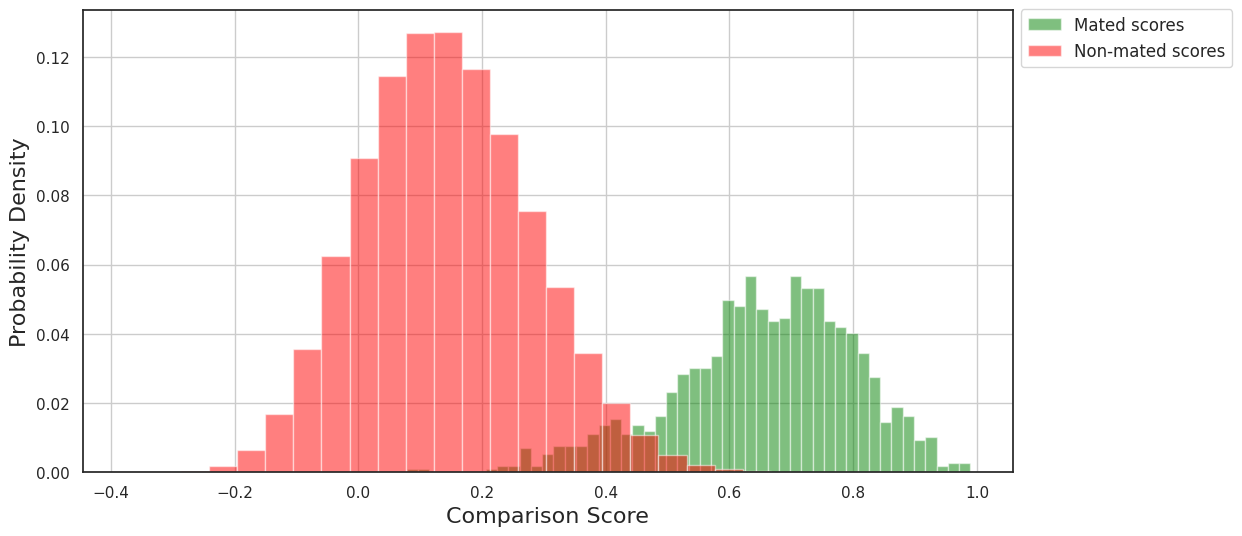

In [27]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

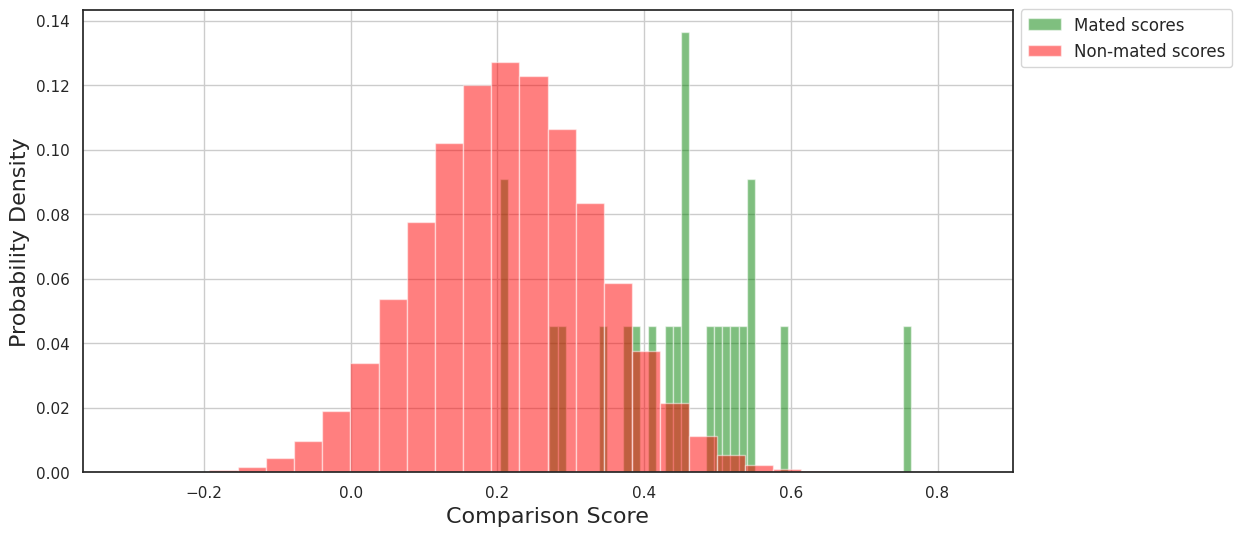

In [28]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)